In [4]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Simulate data

In [5]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))
con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
paradigm = np.vstack([sfs_seq, con_seq])


In [6]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [7]:
parameters = pd.DataFrame({
    #                                
    'width_r'           : np.array([   1.28,   1.50,   1.00,   1.00,]), # [CSF parameters]    
    'SFp'               : np.array([   2.50,   1.00,   4.00,   2.00,]), # 
    'CSp'               : np.array([ 166.00, 100.00,  80.00,  40.00,]), # 
    'width_l'           : np.array([   0.68,   0.68,   0.68,   0.68,]), # 
    'crf_exp'           : np.array([   1.50,   1.50,   2.50,   3.00,]), # [CRF parameter]
    'amplitude'         : np.array([   1.00,   1.00,   1.00,   2.00,]), # [fMRI parameters]
    'baseline'          : np.array([   0.00,   0.00,   1.00,   0.00,]), # 
    # 'hrf_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]), # 
    # 'hrf_2'             : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    }).astype('float32')



In [8]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

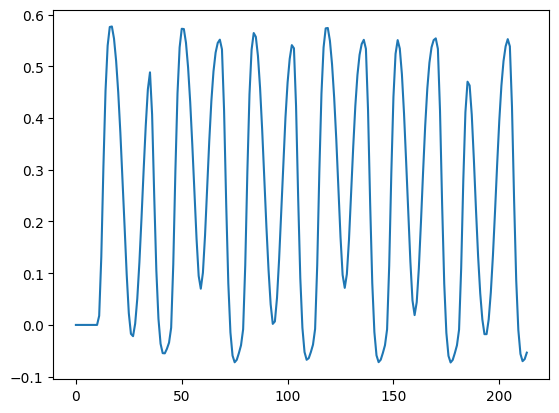

In [9]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=sfs_seq,  
    CON_seq=con_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred.iloc[:,0])

# MCMC - lets explore...

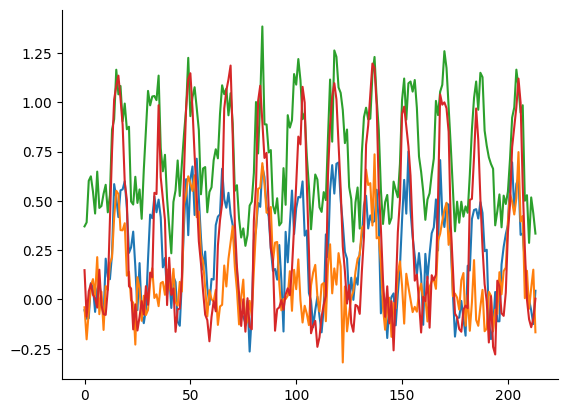

In [13]:

data = model.simulate(noise=.1)
data.plot(legend=False)
sns.despine()
    

In [77]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
fitter = BPRF(model, data)
cfitter = ParameterFitter(model, data, model.paradigm)

In [78]:
grid_pars = cfitter.fit_grid(
    width_r=np.linspace(0, 3, 10),
    SFp=np.linspace(0, 6, 10),
    CSp=np.linspace(50, 200, 10),
    width_l=[0.68],
    crf_exp=np.linspace(1, 3, 10),
    
    baseline=[0.0],
    amplitude=[1.0],
    use_correlation_cost=True
    )
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
ols_pars

Working with chunk size of 778816
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
source,,,,,,,
0,1.333333,2.666667,183.333328,0.68,1.666667,1.000000,0.000000
1,2.000000,1.333333,83.333336,0.68,1.222222,1.000000,0.000000
2,1.000000,4.666667,83.333336,0.68,2.333333,0.958017,0.759900
3,1.000000,2.000000,50.000000,0.68,3.000000,1.695500,0.037244


In [83]:
a = fitter.fit(
    init_pars=ols_pars,
)

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 4
(4, 7)
[<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([  1.3333334 ,   2.6666667 , 183.33333   ,   0.68      ,
         1.6666666 ,   0.54132485,   0.        ], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=
array([ 2.        ,  1.3333334 , 83.333336  ,  0.68      ,  1.2222222 ,
        0.54132485,  0.        ], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=
array([ 1.        ,  4.6666665 , 83.333336  ,  0.68      ,  2.3333333 ,
        0.47407174,  0.75990015], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=
array([1.000000e+00, 2.000000e+00, 5.000000e+01, 6.800000e-01,
       3.000000e+00, 1.492762e+00, 3.724435e-02], dtype=float32)>]
Running HMC...


In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

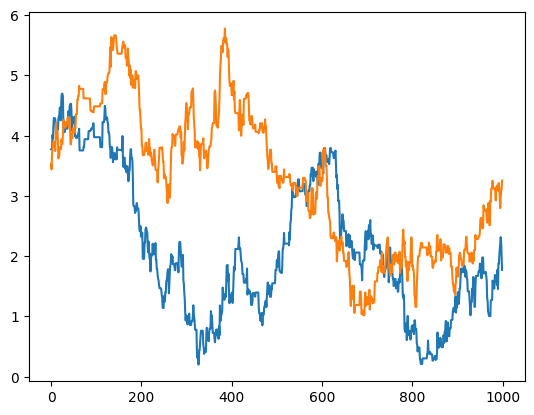

In [98]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [32]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))


<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[1.3333334e+00, 2.6666667e+00, 1.8333333e+02, 6.8000001e-01,
        1.6666666e+00, 5.4132485e-01, 0.0000000e+00],
       [2.0000000e+00, 1.3333334e+00, 8.3333336e+01, 6.8000001e-01,
        1.2222222e+00, 5.4132485e-01, 0.0000000e+00],
       [1.0000000e+00, 4.6666665e+00, 8.3333336e+01, 6.8000001e-01,
        2.3333333e+00, 4.7407174e-01, 7.5990015e-01],
       [1.0000000e+00, 2.0000000e+00, 5.0000000e+01, 6.8000001e-01,
        3.0000000e+00, 1.4927620e+00, 3.7244350e-02]], dtype=float32)>